In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import unicodedata
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

__Data Import__  
Our data comes from oddsportal.com and contains American-style betting odds and results for this current football season and 13 prior seasons.  Our data was collected on November 16th, 2021, so more recent games are excluded from our study.  

American-style betting: Negative betting odds indicate expected winners ("betting favorites"), and positive ones indicate expected losers ("underdogs").  The absolute value of negative betting odds indicates how much you would have had to bet to win $100 if you won (the bet "hits").  The absolute value of positive betting odds indicates how much you stand to win if you bet $100 and it hits.  So, an odds of -420 means you would have to bet $420 to win $100 and walk away with $520.  An odds of 420 means you would win $420 if you bet $100 and will then walk away with $520.  
There are some rare cases when there are two betting favorites playing each other and both of their odds are negative.  There are even some cases when teams have the same odds!  

Extreme Points: There are some graphs below that have some "extreme points" removed.  These are essentially outliers, but they are not chosen for removal by standard deviation or mean analysis but just by removing the _x_ highest or lowest points when _x_ extreme points are removed.

In [3]:
data = pd.read_csv("Odds Portal Data.csv",na_values = "-")
data = data.loc[~data["Home Odds"].isna()]
data = data.loc[~data["Away Odds"].isna()]

In [4]:
data.head()

,Season,Date,Special Game,Time,Home Team,Away Team,Home Score,Away Score,OT,Winner,Home Odds,Away Odds,B's
0,2021/22,11/16/2021,NaN,1:15,San Francisco 49ers,Los Angeles Rams,31,10,False,Home,158.0,-182.0,13
1,2021/22,11/15/2021,NaN,1:20,Las Vegas Raiders,Kansas City Chiefs,14,41,False,Away,129.0,-149.0,13
2,2021/22,11/14/2021,NaN,21:25,Denver Broncos,Philadelphia Eagles,13,30,False,Away,-106.0,-110.0,13
3,2021/22,11/14/2021,NaN,21:25,Green Bay Packers,Seattle Seahawks,17,00,False,Home,-172.0,149.0,13
4,2021/22,11/14/2021,NaN,21:05,Arizona Cardinals,Carolina Panthers,10,34,False,Away,-323.0,265.0,13


__Initial Data Exploration__  
In order to get a feel for the data before analyzing it with more complexity, we plotted the following:
1. Home vs Away score for each season - There were no visible trends and scores had high variability
2. Score vs Odds - There is some negative correlation visible, but some extreme odds were shrinking the plot
3. Score vs Odds With 12 Extreme Points Removed - Now that the plot shrinking is minimized, it is clear that while the negative correlation previously observed does exist, the correlation is not as strong in the previous plot.  The plot-shrinking phenomenon made points appear closer together and thereby more in line with each other and correlated
4. Score vs Odds for Game Winners - No trend is easily visible due to extreme values shrinking the plot
5. Score vs Odds for Game Winners With 6 Extreme Points Removed = There does not seem to be a correlation between these two variables, although most betting favorites did end up winning.
6. Score vs Odds for Game Losers - There seems to be a weak correlation that teams who were more expected to lose did more poorly
7. Score vs Odds for Betting Favorites With 6 Extreme Points Removed - There is no visible correlation between score and odds within this category, which implies that the weak correlation visible when both betting favorites and underdogs were displayed was more indicative of the differences between scoring in favorites and underdogs rather than a true correlation between odds and score.
8. Log Count of Wins and Losses by Odds Range - This shows that odds are more an expression of confidence of a win or a loss rather than having any correlation to score, which we have seen previously doesn't really exist.

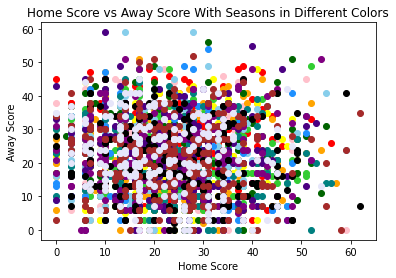

In [5]:
seasons = list(set(data["Season"]))

colors = ["pink","red","orange","yellow","limegreen","darkgreen","skyblue","dodgerblue","teal","indigo","purple","black","brown","lavender"]

plt.yticks([i for i in range(0,61,10)])
plt.xlabel("Home Score")
plt.ylabel("Away Score")
plt.title("Home Score vs Away Score With Seasons in Different Colors")

for i in range(len(seasons)):
    seasondata = data.loc[data.Season==seasons[i]]
    x = np.array(seasondata["Home Score"]).astype(int)
    y = np.array(seasondata["Away Score"]).astype(int)
    plt.scatter(x,y,c=colors[i])

Text(0.5, 1.0, 'Score vs Betting Odds For All Data')

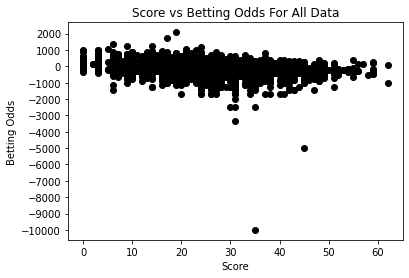

In [6]:
x = list(data["Home Score"]) + list(data["Away Score"])
y = list(data["Home Odds"]) + list(data["Away Odds"])

plt.yticks([i for i in range(-10000,2001,1000)])
plt.scatter(x,y,c="black")
plt.xlabel("Score")
plt.ylabel("Betting Odds")
plt.title("Score vs Betting Odds For All Data")

Text(0.5, 1.0, 'Score vs Betting Odds With 12 Extreme Points Removed')

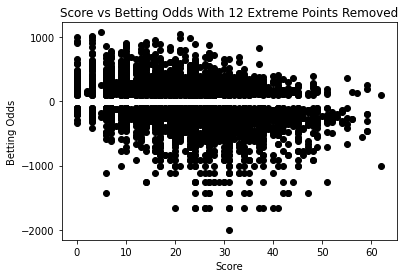

In [7]:
x = list(data["Home Score"]) + list(data["Away Score"])
y = list(data["Home Odds"]) + list(data["Away Odds"])

for i in range(6):
    #remove point with max y value
    ind = y.index(max(y))
    y = y[:ind]+y[ind+1:]
    x = x[:ind]+x[ind+1:]

    #remove point with min y value
    ind = y.index(min(y))
    y = y[:ind]+y[ind+1:]
    x = x[:ind]+x[ind+1:]

plt.yticks([i for i in range(-10000,2001,1000)])
plt.scatter(x,y,c="black")
plt.xlabel("Score")
plt.ylabel("Betting Odds")
plt.title("Score vs Betting Odds With 12 Extreme Points Removed")

Text(0.5, 1.0, 'Score vs Betting Odds for Game Winners')

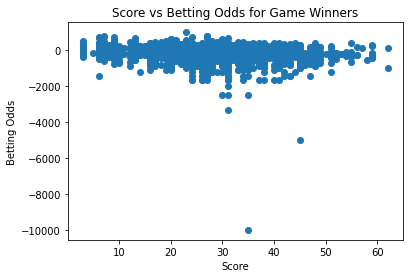

In [8]:
noties = data.loc[data["Winner"] != "Tie"].reset_index()

winnerodds = [noties["Home Odds"][i] if noties["Winner"][i] == "Home" else noties["Away Odds"][i] for i in range(len(noties))]
winnerscore = [noties["Home Score"][i] if noties["Winner"][i] == "Home" else noties["Away Score"][i] for i in range(len(noties))]

plt.scatter(winnerscore,winnerodds)
plt.ylabel("Betting Odds")
plt.xlabel("Score")
plt.title("Score vs Betting Odds for Game Winners")

Percent of winners who were betting favorites:  67 %


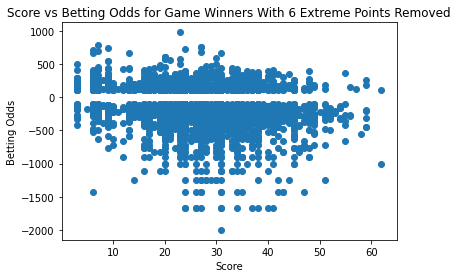

In [9]:
noties = data.loc[data["Winner"] != "Tie"]
noties = noties.loc[noties["Home Odds"] >= -2000].reset_index()

winnerodds = [noties["Home Odds"][i] if noties["Winner"][i] == "Home" else noties["Away Odds"][i] for i in range(len(noties))]
winnerscore = [noties["Home Score"][i] if noties["Winner"][i] == "Home" else noties["Away Score"][i] for i in range(len(noties))]

plt.scatter(winnerscore,winnerodds)
plt.ylabel("Betting Odds")
plt.xlabel("Score")
plt.title("Score vs Betting Odds for Game Winners With 6 Extreme Points Removed")

print("Percent of winners who were betting favorites: ",int(round(np.sum([1 if o < 0 else 0 for o in winnerodds])/len(winnerodds),2)*100),"%")

Percent of losers who were betting favorites:  38 %


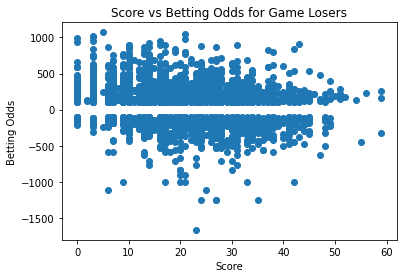

In [10]:
loserodds = [noties["Home Odds"][i] if noties["Winner"][i] == "Away" else noties["Away Odds"][i] for i in range(len(noties))]
loserscore = [int(noties["Home Score"][i]) if noties["Winner"][i] == "Away " else int(noties["Away Score"][i]) for i in range(len(noties))]

plt.scatter(loserscore,loserodds)
plt.ylabel("Betting Odds")
plt.xlabel("Score")
plt.title("Score vs Betting Odds for Game Losers")

print("Percent of losers who were betting favorites: ",int(round(np.sum([1 if o < 0 else 0 for o in loserodds])/len(loserodds),2)*100),"%")

Text(0.5, 1.0, 'Score vs Betting Odds for Betting Favorites with 6 Extreme Points Removed')

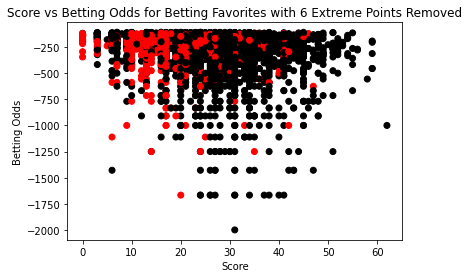

In [11]:
bfodds = [min(noties["Home Odds"][i],noties["Away Odds"][i]) for i in range(len(noties))]
bfwins = [1 if (noties["Home Odds"][i] < 0 and noties["Winner"][i] == "Home") or (
    noties["Away Odds"][i] < 0 and noties["Winner"][i] == "Away") else 0 for i in range(len(noties))]
bfscore = [noties["Home Score"][i] if noties["Home Odds"][i] < 0 else int(noties["Away Score"][i]) for i in range(len(noties))]

color = ["black" if w else "red" for w in bfwins]

plt.scatter(bfscore,bfodds,c=color)
plt.xlabel("Score")
plt.ylabel("Betting Odds")
plt.title("Score vs Betting Odds for Betting Favorites with 6 Extreme Points Removed")

## Black ultimately win and red ultimately lose

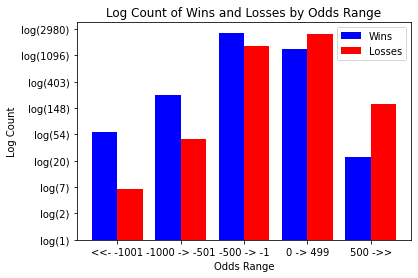

In [12]:
data.reset_index()

winners = list(data["Winner"])

allodds = list(data["Home Odds"]) + list(data["Away Odds"])
allresults = ["win" if winners[i] == "Home" else ("tie" if winners[i] == "Tie" else "loss") for i in range(len(data))]
allresults += ["win" if winners[i] == "Away" else ("tie" if winners[i] == "Tie" else "loss") for i in range(len(data))]

# bar number is less than or equal to true value
bars = {i:{"win":0,"tie":0,"loss":0} for i in range(-1500,501,500)}

for i in range(len(allodds)):
    bar = (allodds[i]//500)*500
    if bar < -1500:
        bar = -1500
    if bar > 500:
        bar = 500
    
    bars[bar][allresults[i]] += 1

barlist = list(bars.keys())
barlist.sort()

wins = [math.log(1) if bars[b]["win"] == 0 else math.log(bars[b]["win"]) for b in barlist]
ties = [math.log(1) if bars[b]["tie"] == 0 else math.log(bars[b]["tie"]) for b in barlist]
losses = [math.log(1) if bars[b]["loss"] == 0 else math.log(bars[b]["loss"]) for b in barlist]

barlabels = [str(barlist[i-1]) + " -> " + str(barlist[i]-1) for i in range(1,len(barlist))]
barlabels[0] = "<<- -1001"
barlabels.append("500 ->>")

wpos = [i for i in range(len(barlist))]
lpos = [i+0.4 for i in range(len(barlist))]
labelpos = [i+0.2 for i in range(len(barlist))]

plt.xticks(labelpos,labels=barlabels)

plt.xlabel("Odds Range")
plt.ylabel("Log Count")
plt.title("Log Count of Wins and Losses by Odds Range")
plt.yticks([i for i in range(9)],labels=["log(" + str(int(math.e**i))+")" for i in range(9)])
plt.bar(wpos,wins,color="blue",label="Wins",width=0.4)
plt.bar(lpos,losses,color="red",label="Losses",width=0.4)
plt.legend()

__Modeling and Prediction__

In [13]:
data.head()

,Season,Date,Special Game,Time,Home Team,Away Team,Home Score,Away Score,OT,Winner,Home Odds,Away Odds,B's
0,2021/22,11/16/2021,NaN,1:15,San Francisco 49ers,Los Angeles Rams,31,10,False,Home,158.0,-182.0,13
1,2021/22,11/15/2021,NaN,1:20,Las Vegas Raiders,Kansas City Chiefs,14,41,False,Away,129.0,-149.0,13
2,2021/22,11/14/2021,NaN,21:25,Denver Broncos,Philadelphia Eagles,13,30,False,Away,-106.0,-110.0,13
3,2021/22,11/14/2021,NaN,21:25,Green Bay Packers,Seattle Seahawks,17,00,False,Home,-172.0,149.0,13
4,2021/22,11/14/2021,NaN,21:05,Arizona Cardinals,Carolina Panthers,10,34,False,Away,-323.0,265.0,13


In [42]:
data = data.sample(frac=1).reset_index(drop=True)

onehotseasons = pd.get_dummies(data["Season"])
onehotspecial = pd.get_dummies(data["Special Game"],drop_first=True)
onehothome = pd.get_dummies(data["Home Team"],prefix="H")
onehotaway = pd.get_dummies(data["Away Team"].map(lambda x: x if "\xa0" not in x else x[:-1]),prefix="A")
intawayscore = data["Away Score"].astype(int)
intot = data["OT"].astype(int)
onehotwinner = pd.get_dummies(data["Winner"]).iloc[:,:2]

modelin = pd.concat([
    onehotseasons
    ,onehotspecial
    ,onehothome
    ,onehotaway
    #,data["Home Score"]
    #,intawayscore
    #,intot
    #,onehotwinner
    ,data["Home Odds"]
    ,data["Away Odds"]
    ],axis=1)

modelout = pd.concat([
    data["Home Score"]
    ,intawayscore
    ,intot
    ,onehotwinner
],axis=1)

cutoff = int(.7*len(modelin))

trainin = modelin[:cutoff]
trainout = modelout[:cutoff]
testin = modelin[cutoff:]
testout = modelout[cutoff:]

Mean of differences between model output and true values: 0.01894888561936483
Standard deviation of those same differnces: 9.544998982534853


Text(0, 0.5, 'Count')

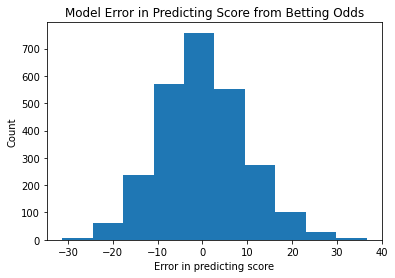

In [94]:
scoremodel = LinearRegression().fit(trainin,trainout.iloc[:,:2])
modelout = scoremodel.predict(testin)
scoretestout = testout.iloc[:,:2].to_numpy()

diffs = scoretestout-modelout

print("Mean of differences between model output and true values:",np.mean(diffs))
print("Standard deviation of those same differnces:",np.std(diffs))

plt.hist(np.ravel(diffs))
plt.title("Model Error in Predicting Score from Betting Odds")
plt.xlabel("Error in predicting score")
plt.ylabel("Count")

In [84]:
OTmodel = SGDClassifier().fit(trainin,trainout.iloc[:,2])
modelout = OTmodel.predict(testin)

results = ["true neg" if modelout[i] == 0 and testout.iloc[i,2] == 0 else (
    "true pos" if modelout[i] == 1 and testout.iloc[i,2] == 1 else (
    "false neg" if modelout[i] == 0 else "false pos"
)) for i in range(len(modelout))]

print("false positives =",results.count("false pos"))
print("true positives =",results.count("true pos"))
print("should be positives =",results.count("false neg")+results.count("true pos"))
print("false negatives =",results.count("false neg"))
print("true negatives =",results.count("true neg"))
print("should be negatives =",results.count("false pos")+results.count("true neg"))

false positives = 1
true positives = 0
should be positives = 70
false negatives = 70
true negatives = 1227
should be negatives = 1228


In [93]:
winmodel = SGDClassifier().fit(trainin,trainout.iloc[:,4])
winmodel.score(testin,testout.iloc[:,4])

0.6579352850539292

Mean of differences between model output and true values: 0.20565204425126754
Standard deviation of those same differnces: 9.761907111302602


Text(0, 0.5, 'Count')

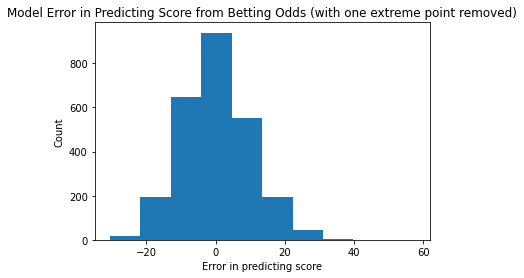

In [97]:
scoremodel = MLPRegressor().fit(trainin,trainout.iloc[:,:2])
modelout = scoremodel.predict(testin)
scoretestout = testout.iloc[:,:2].to_numpy()

diffs = scoretestout-modelout

print("Mean of differences between model output and true values:",np.mean(diffs))
print("Standard deviation of those same differnces:",np.std(diffs))

plt.hist(np.ravel(np.sort(diffs))[:-1])
plt.title("Model Error in Predicting Score from Betting Odds (with one extreme point removed)")
plt.xlabel("Error in predicting score")
plt.ylabel("Count")

In [99]:
OTmodel = MLPClassifier().fit(trainin,trainout.iloc[:,2])
modelout = OTmodel.predict(testin)

results = ["true neg" if modelout[i] == 0 and testout.iloc[i,2] == 0 else (
    "true pos" if modelout[i] == 1 and testout.iloc[i,2] == 1 else (
    "false neg" if modelout[i] == 0 else "false pos"
)) for i in range(len(modelout))]

print("false positives =",results.count("false pos"))
print("true positives =",results.count("true pos"))
print("should be positives =",results.count("false neg")+results.count("true pos"))
print("false negatives =",results.count("false neg"))
print("true negatives =",results.count("true neg"))
print("should be negatives =",results.count("false pos")+results.count("true neg"))

false positives = 0
true positives = 0
should be positives = 70
false negatives = 70
true negatives = 1228
should be negatives = 1228


In [103]:
winmodel = MLPClassifier().fit(trainin,trainout.iloc[:,4])
winmodel.score(testin,testout.iloc[:,4])

0.6440677966101694

Mean of differences between model output and true values: 0.02157164869029276
Standard deviation of those same differnces: 13.091223020793418


Text(0, 0.5, 'Count')

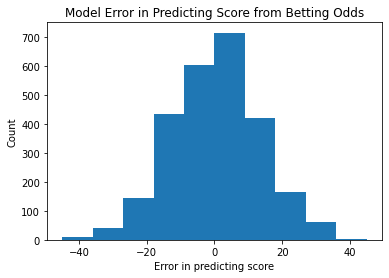

In [129]:
scoremodel = DecisionTreeRegressor().fit(trainin,trainout.iloc[:,:2])
modelout = scoremodel.predict(testin)
scoretestout = testout.iloc[:,:2].to_numpy()

diffs = scoretestout-modelout

print("Mean of differences between model output and true values:",np.mean(diffs))
print("Standard deviation of those same differnces:",np.std(diffs))

plt.hist(np.ravel(diffs))
plt.title("Model Error in Predicting Score from Betting Odds")
plt.xlabel("Error in predicting score")
plt.ylabel("Count")

In [125]:
OTmodel = DecisionTreeClassifier().fit(trainin,trainout.iloc[:,2])
modelout = OTmodel.predict(testin)

results = ["true neg" if modelout[i] == 0 and testout.iloc[i,2] == 0 else (
    "true pos" if modelout[i] == 1 and testout.iloc[i,2] == 1 else (
    "false neg" if modelout[i] == 0 else "false pos"
)) for i in range(len(modelout))]

print("false positives =",results.count("false pos"))
print("true positives =",results.count("true pos"))
print("should be positives =",results.count("false neg")+results.count("true pos"))
print("false negatives =",results.count("false neg"))
print("true negatives =",results.count("true neg"))
print("should be negatives =",results.count("false pos")+results.count("true neg"))

false positives = 49
true positives = 5
should be positives = 70
false negatives = 65
true negatives = 1179
should be negatives = 1228


In [108]:
winmodel = DecisionTreeClassifier().fit(trainin,trainout.iloc[:,4])
winmodel.score(testin,testout.iloc[:,4])

0.5816640986132512